In [1]:
import os
import random
from glob import glob
from typing import Union, List

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm import tqdm

from constants import LESION_SIZES

NIB_EXT = ".nii.gz"
DATA_DIR = "data/ATLAS_2/Training"

scans_filepaths = sorted(glob(os.path.join(DATA_DIR, "**/*_T1w" + NIB_EXT), recursive=True))
masks_filepaths = sorted(glob(os.path.join(DATA_DIR, "**/*T1lesion_mask" + NIB_EXT), recursive=True))

## Lesion Statistics
- Lesion volume distribution
- Lesion count per subject
- Lesion location distribution

Retrieving lesion size distribution data:   0%|          | 0/655 [00:00<?, ?it/s]/media/neurone-pc11/Volume/Angelo/strokeformer/utils/helpers.py:198: RuntimeWarning: invalid value encountered in divide
  lesion_area = np.nan_to_num(np.divide(lesion_size, brain_area), nan=0)
Retrieving lesion size distribution data: 100%|██████████| 655/655 [02:18<00:00,  4.73it/s]


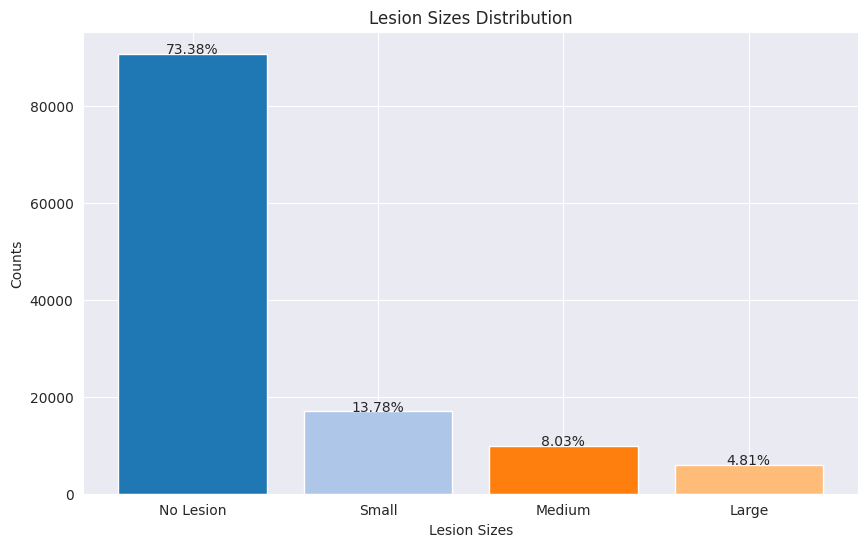

In [2]:
from utils import plot_lesion_size_distribution

plot_lesion_size_distribution(scans_filepaths, masks_filepaths)

In [2]:
from utils import get_lesion_size_distribution_metadata

lesion_size_distribution_metadata = get_lesion_size_distribution_metadata(scans_filepaths, masks_filepaths)
total_voxels = lesion_size_distribution_metadata["sick_voxels"] + lesion_size_distribution_metadata["healthy_voxels"]
sick_healthy_voxel_ratio = lesion_size_distribution_metadata["healthy_voxels"] / lesion_size_distribution_metadata["sick_voxels"]
total_slices = lesion_size_distribution_metadata["sick_slices_num"] + lesion_size_distribution_metadata["healthy_slices_num"]
sick_healthy_slice_ratio = lesion_size_distribution_metadata["healthy_slices_num"] / lesion_size_distribution_metadata["sick_slices_num"]

print(f"Total voxels: {total_voxels}\n"
      f"Total sick voxels: {lesion_size_distribution_metadata['sick_voxels']}\n"
      f"Sick/Healthy voxel ratio: 1:{sick_healthy_voxel_ratio:.2f}\n\n"
      f"Total slices: {total_slices}\n"
      f"Total healthy slices: {lesion_size_distribution_metadata['healthy_slices_num']}\n"
      f"Total sick slices: {lesion_size_distribution_metadata['sick_slices_num']}\n"
      f"Sick/Healthy slices ratio: 1:{sick_healthy_slice_ratio:.2f}\n\n"
      f"Average number of lesions per patient: {np.mean(lesion_size_distribution_metadata['num_lesions_per_patient']):.2f}")

Retrieving lesion size distribution data:   0%|          | 0/655 [00:00<?, ?it/s]/media/neurone-pc11/Volume/Angelo/strokeformer/utils/helpers.py:198: RuntimeWarning: invalid value encountered in divide
  lesion_area = np.nan_to_num(np.divide(lesion_size, brain_area), nan=0)
Retrieving lesion size distribution data: 100%|██████████| 655/655 [02:39<00:00,  4.12it/s]

Total voxels: 1622845765.0
Total sick voxels: 21760513
Sick/Healthy voxel ratio: 1:73.58

Total slices: 123795
Total healthy slices: 90837
Total sick slices: 32958
Sick/Healthy slices ratio: 1:2.76

Average number of lesions per patient: 4.11


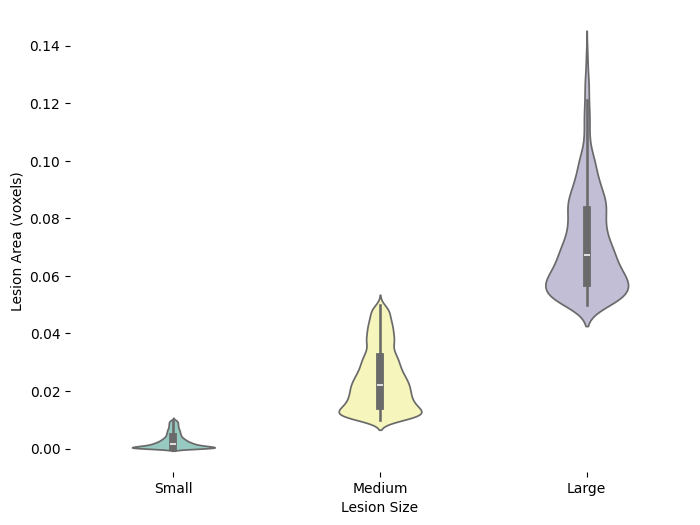

In [4]:
def plot_violin_lesion_size_distribution(area_counts: Union[np.ndarray, List[List[int]], List[np.ndarray]], labels, figsize=(8, 6), palette="Set3"):
    records = []
    for area_count, l in zip(area_counts, labels):
        for area in area_count:
            records.append(({"Lesion Size": l, "Lesion Area (voxels)": area}))

    df = pd.DataFrame(records, columns=["Lesion Area (voxels)", "Lesion Size"])

    plt.figure(figsize=figsize)
    sns.violinplot(data=df, x="Lesion Size", y="Lesion Area (voxels)", hue="Lesion Size", palette=palette, gap=0.5)
    sns.despine(left=True, bottom=True)

plot_violin_lesion_size_distribution(counts_per_size, [size for size in LESION_SIZES if size != "No Lesion"])

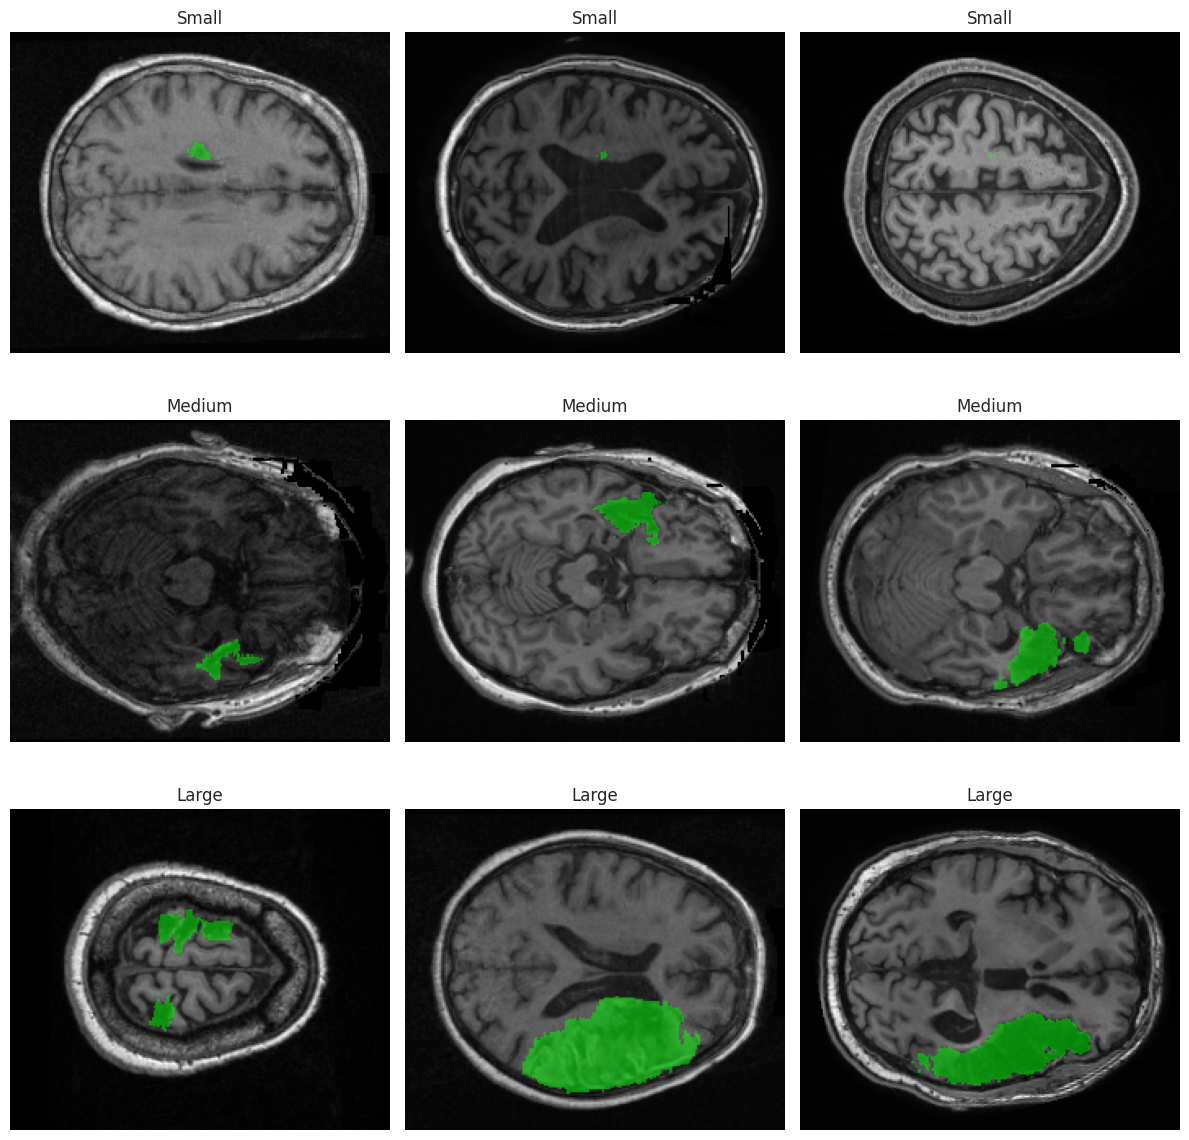

In [5]:
from utils import load_volume, generate_overlayed_slice

def plot_mask_slice(scan_filepath, mask_filepath, slice_idx, category, ax=None, figsize=(8, 6)):
    scan = load_volume(scan_filepath)
    mask = load_volume(mask_filepath)

    scan_slice = scan[..., slice_idx]
    mask_slice = mask[..., slice_idx]

    overlayed_slice = generate_overlayed_slice(scan_slice, mask_slice, color=(0, 255, 0))

    if ax is None:
        plt.figure(figsize=figsize)
        plt.imshow(overlayed_slice, cmap="gray")
        plt.title(f"{category}")
        plt.axis("off")
        plt.show()
    else:
        ax.imshow(overlayed_slice, cmap="gray")
        ax.set_title(f"{category}")
        ax.axis("off")

fig, axs = plt.subplots(3, 3, figsize=(12, 12))
masks_samples = []

for i, size in enumerate(LESION_SIZES[1:]):
    samples = random.choices(lesion_size_distribution_metadata[size]["filepaths"], k=3)

    for j, (scan_filepath, masks_filepath, slice_idx) in enumerate(samples):
        plot_mask_slice(scan_filepath, masks_filepath, slice_idx, size, ax=axs[i, j])

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Lesions Per Patient')

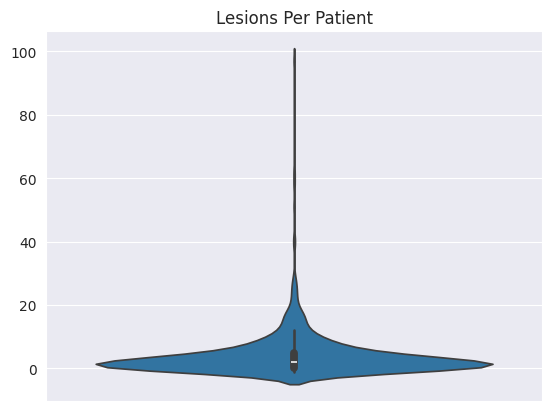

In [3]:
sns.violinplot(lesion_size_distribution_metadata['num_lesions_per_patient'])
plt.title("Lesions Per Patient")

Computing location heatmap: 100%|██████████| 655/655 [01:21<00:00,  8.00it/s]


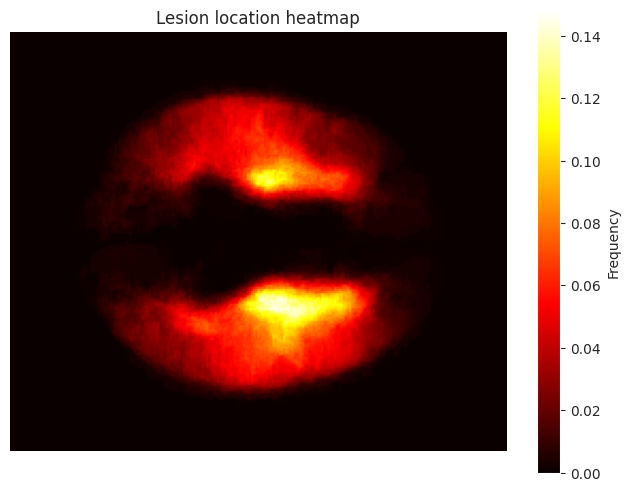

In [8]:
from utils import load_volume

def plot_lesion_heatmap(masks_filepaths: List[str], mask_shape: tuple[int, int, int] = (197, 233, 189), figsize=(8, 6)):
    heatmap = np.zeros(mask_shape, dtype=np.float32)

    for mask_filepath in tqdm(masks_filepaths, desc="Computing location heatmap"):
        mask = load_volume(mask_filepath)
        heatmap += (mask > 0).astype(np.float32)

    heatmap /= len(masks_filepaths)

    if heatmap.ndim == 3:
        mid_slice = heatmap.shape[-1] // 2
        heatmap = heatmap[..., mid_slice]

    plt.figure(figsize=figsize)
    plt.imshow(heatmap, cmap="hot")
    plt.colorbar(label="Frequency")
    plt.title(f"Lesion location heatmap")
    plt.axis("off")
    plt.show()

plot_lesion_heatmap(masks_filepaths)